# Load Data

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm.notebook import tqdm
import json
import ast
import math
import re
from currency_converter import CurrencyConverter
c = CurrencyConverter()
import pandas as pd
DATAPATH = './Data'

In [2]:
n_pages = 52
for i in range(n_pages):
    if i == 0:
        sampleData = pd.read_csv(os.path.join(DATAPATH, f'{i}.csv'))
    else:
        sampleData = sampleData.append(pd.read_csv(os.path.join(DATAPATH, f'{i}.csv')))

In [3]:
extractedDf = sampleData[["required_age", 
                          "controller_support",
                          "dlc", 
                          "supported_languages", 
                          "pc_requirements",
                          "developers",
                          "platforms", 
                          "release_date",
                          "price_overview", 
                          "categories", 
                          "genres", 
                          "recommendations"]].copy()
extractedDf['controller_support'] = extractedDf['controller_support'].fillna(0)
extractedDf['dlc'] = extractedDf['dlc'].fillna(0)
extractedDf['controller_support'] = extractedDf['controller_support'].fillna(0)
extractedDf = extractedDf.dropna()

In [5]:
def moneyConversion(fromCurrency, fromAmt, to= "USD"):
    ret = c.convert(fromAmt, fromCurrency, to)
    return ret

attributes = pd.DataFrame(extractedDf.iloc[:, :12])
label = pd.DataFrame(extractedDf.iloc[:, -1])


retDf = pd.DataFrame({'Required_Age':[],
                      'Controller_support':[],
                      'DLC':[],
                      'Supported_languages':[],
                      'PC_Requirements':[],
                      'Developers':[],
                      'Platforms':[],
                      'Release_year':[],
                      'Currency(USD)':[], 
                      'Categories(ID)':[], 
                      'Genres(ID)':[], 
                      'Label(Binary Classification)':[], 
                      'Label(Regression)':[]})

for i in tqdm(range(len(extractedDf))):
    attributesElement = attributes.iloc[i]

    if  type(attributesElement['required_age']) == str:
        age = int(re.sub('[^0-9]','', attributesElement['required_age']))
    else:
        age = int(attributesElement['required_age'])

    if attributesElement['controller_support'] == 'full':
        controler = 1
    else:
        controler = 0

    if attributesElement['dlc'] != 0 :
        num_dlc = len(ast.literal_eval(attributesElement['dlc']))
    else:
        num_dlc = 0
    
    languages = attributesElement['supported_languages'].replace('<strong>*</strong>', '')
    languages = languages.replace('<br>', '')
    languages = len(languages.split(','))

    req = attributesElement['pc_requirements'].lower()
    req = re.sub("\<.*?\>"," ",req)
    req = req.replace('\'', ' ')
    req = req.replace(',', ' ')
    req = req.replace('\\r', ' ')
    req = req.replace('\\n', ' ')
    req = req.replace('\\t', ' ')
    req = req.split(' ')
    req = list(filter(('').__ne__, req))
    proc = None
    if 'processor:' in req:
        procIdx = req.index('processor:')
        proc = ''.join(req[procIdx: procIdx + 6])
        if 'hz' in proc:
            proc = proc[proc.index('hz')-4 :proc.index('hz')+2]
        else:
            proc = None
    elif 'processor' in req:
        procIdx = req.index('processor')
        proc = ''.join(req[procIdx - 2:procIdx+1])
        if 'hz' in proc:
            proc = proc[proc.index('hz')-4 :proc.index('hz')+2]
        else:
            proc = None
    
    ram = None
    if 'memory:' in req and 'ram' in req:
        ramIdx = req.index('ram')
        ram = ''.join(req[ramIdx: ramIdx + 5])
        if 'mb' in ram:
            ram = ''.join(ram[ram.index('mb') - 3:ram.index('mb') + 2])
        elif 'gb' in ram:
            ram = ''.join(ram[ram.index('gb') - 3:ram.index('gb') + 2])
        else:
            ram = None
    elif 'ram' in req:
        ramIdx = req.index('ram')
        ram = ''.join(req[ramIdx: ramIdx + 5])
        if 'mb' in ram:
            ram = ''.join(ram[ram.index('mb') - 3:ram.index('mb') + 2])
        elif 'gb' in ram:
            ram = ''.join(ram[ram.index('gb') - 3:ram.index('gb') + 2])
        else:
            ram = None
    if ram: 
        ram = re.findall('[0-9]+.b', ram)
        ram = ram[0] if len(ram)>0 else None

    
    requirements = [proc, ram]
    

    developers = attributesElement['developers'][1:-1]

    platform = ast.literal_eval(attributesElement['platforms'])
    num_plat = 0
    for k, v in platform.items():
        if v == True:
            num_plat += 1

    if len(ast.literal_eval(attributesElement['release_date'])['date'])>0:
        try:
            year = int(ast.literal_eval(attributesElement['release_date'])['date'].split(",")[-1])
        except:
            try:
                year = int(ast.literal_eval(attributesElement['release_date'])['date'].split(" ")[-1])
            except:
                year = None
                for y in ast.literal_eval(attributesElement['release_date'])['date'].split(" "):
                    if len(y) == 4 and y.isnumeric():
                        year = int(y)
                        continue
                if year == None: raise
    else:
        year = 0

    priceRaw = attributesElement["price_overview"]
    priceRaw = ast.literal_eval(priceRaw)

    try:
        currencyInUS = round(moneyConversion(priceRaw['currency'], priceRaw['final']/100),2)
    except:
        if priceRaw['currency'] == 'TWD':
            mult = 0.035

        currencyInUS = round(mult * priceRaw['final']/100, 2)


    categories = attributesElement['categories']
    categories = ast.literal_eval(categories)
    categoriesID = np.array(list(i['id'] for i in categories))

    genres = attributesElement['genres']
    genres = ast.literal_eval(genres)
    genresID = np.array(list(int(i['id']) for i in genres))

    labelElement = label.iloc[i]['recommendations']

    labelRaw = ast.literal_eval(labelElement)
    labelRawRegression = labelRaw['total']
    labelRawClassification = 1 if labelRaw['total'] > 600 else 0

    
    retDf = retDf.append({'Required_Age':age,
                      'Controller_support':controler,
                      'DLC':num_dlc,
                      'Supported_languages':languages,
                      'PC_Requirements':requirements,
                      'Developers':developers,
                      'Platforms':num_plat,
                      'Release_year':year,
                      'Currency(USD)':currencyInUS, 
                      'Categories(ID)':categoriesID,
                      'Genres(ID)':genresID,
                      'Label(Binary Classification)':labelRawClassification,
                      'Label(Regression)':labelRawRegression},
                      ignore_index= True)
    
retDf.loc[retDf['Release_year']==0, 'Release_year'] = retDf['Release_year'].median()

  0%|          | 0/10608 [00:00<?, ?it/s]

In [6]:
store = retDf['Categories(ID)'].apply(max)
max_num = max(store)
tmpStore = retDf['Genres(ID)'].apply(max)
max_num_genres = max(tmpStore)
retDf['RAM']  = 0
retDf['Processor'] = 0

print(max_num, max_num_genres)

for i in tqdm(range(len(retDf))):

    tmpEnc = [0] * max_num
    element = retDf.iloc[i]['Categories(ID)']
    for j in element:
        tmpEnc[j - 1] = 1
    
    tmpEncGenres = [0] * int(max_num_genres)
    elementGenres = retDf.iloc[i]['Genres(ID)']
    for j in elementGenres:
        tmpEncGenres[int(j)-1] = 1
    retDf.loc[i, ['Categories(ID)', 'Genres(ID)']] = [tmpEnc, tmpEncGenres]

    pc_req = retDf.iloc[i]['PC_Requirements'][:]
    retDf.loc[i, ['Processor']] = pc_req[0]
    retDf.loc[i, ['RAM']] = pc_req[1]

retDf['Developers'].replace(to_replace=retDf['Developers'].unique(),
           value= np.random.permutation(list(range(len(retDf['Developers'].unique())))),
           inplace=True)

retDf['Processor'].replace(to_replace=retDf['Processor'].unique(),
           value= list(range(len(retDf['Processor'].unique()))),
           inplace=True)
retDf['RAM'].replace(to_replace=retDf['RAM'].unique(),
           value= list(range(len(retDf['RAM'].unique()))),
           inplace=True)

retDf['Dev_red'] = retDf['Developers']
dummies = pd.get_dummies(retDf['Dev_red'])
idxes = np.where(dummies.values.sum(axis=0) > 10)[0]

cond = ~retDf['Dev_red'].isin(dummies.columns[idxes])
retDf.loc[cond,'Dev_red'] = '>_<'
retDf['Dev_red'] = [list(v) for v in pd.get_dummies(retDf['Dev_red']).values]

retDf['Integer_Encoding'] = retDf["Required_Age"].apply(lambda x: [x]) + \
                            retDf["Controller_support"].apply(lambda x: [x]) + \
                            retDf["DLC"].apply(lambda x: [x]) + \
                            retDf["Supported_languages"].apply(lambda x: [x]) + \
                            retDf["Processor"].apply(lambda x: [x]) + \
                            retDf["RAM"].apply(lambda x: [x]) + \
                            retDf["Platforms"].apply(lambda x: [x]) + \
                            retDf["Release_year"].apply(lambda x: [x]) + \
                            retDf["Dev_red"].apply(lambda x: [x]) + \
                            retDf["Currency(USD)"].apply(lambda x: [x]) + \
                            retDf['Categories(ID)'] + retDf['Genres(ID)']

retDf = retDf[['Required_Age', 'Controller_support', 'DLC', 'Supported_languages', \
               'Processor', 'RAM', 'Developers', 'Platforms', 'Release_year', 'Currency(USD)', \
               'Categories(ID)', 'Genres(ID)', 'Integer_Encoding', 'Label(Binary Classification)', 'Label(Regression)']]
               
retDf['Developers'].replace(to_replace=retDf['Developers'].unique(),
        value= list(range(len(retDf['Developers'].unique()))),
        inplace=True)

retDf = retDf.loc[(retDf['Label(Regression)'] > 600) | (retDf['Label(Regression)'] < 300)][::]

51 74


  0%|          | 0/10608 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [9]:
retDf['Dev_red'] = retDf['Developers']
dummies = pd.get_dummies(retDf['Dev_red'])
idxes = np.where(dummies.values.sum(axis=0) > 10)[0]

cond = ~retDf['Dev_red'].isin(dummies.columns[idxes])
retDf.loc[cond,'Dev_red'] = '>_<'
retDf['Dev_red'] = [list(v) for v in pd.get_dummies(retDf['Dev_red']).values]

retDf['Integer_Encoding'] = retDf["Required_Age"].apply(lambda x: [x]) + \
                            retDf["Controller_support"].apply(lambda x: [x]) + \
                            retDf["DLC"].apply(lambda x: [x]) + \
                            retDf["Supported_languages"].apply(lambda x: [x]) + \
                            retDf["Processor"].apply(lambda x: [x]) + \
                            retDf["RAM"].apply(lambda x: [x]) + \
                            retDf["Platforms"].apply(lambda x: [x]) + \
                            retDf["Release_year"].apply(lambda x: [x]) + \
                            retDf["Currency(USD)"].apply(lambda x: [x]) + \
                            retDf["Dev_red"] + \
                            retDf['Categories(ID)'] + retDf['Genres(ID)']

In [19]:
len(retDf['Dev_red'].iloc[0])

37

(array([1732.,  587.,  281.,  174.,  109.,   54.,   53.,   53.,   35.]),
 array([    0.,  3000.,  6000.,  9000., 12000., 15000., 18000., 21000.,
        24000., 27000.]),
 <a list of 9 Patch objects>)

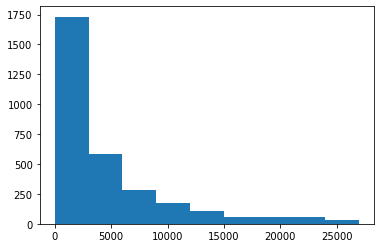

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(10)
y = []
gap = 3e3
x = x* gap

for i in x:
    y.append(sum((i*gap<retDf['Label(Regression)']) & (retDf['Label(Regression)']<(i+1)*gap)))

plt.hist(retDf['Label(Regression)'], bins=x)

In [10]:
retDf.head()

,Required_Age,Controller_support,DLC,Supported_languages,Processor,RAM,Developers,Platforms,Release_year,Currency(USD),Categories(ID),Genres(ID),Integer_Encoding,Label(Binary Classification),Label(Regression),Dev_red
0,0.0,0.0,0.0,8.0,0,0,0,3.0,2000.0,9.09,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 8.0, 0, 0, 3.0, 2000.0, 9.09, ...",1.0,119298.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.0,0.0,0.0,9.0,0,0,0,3.0,1999.0,4.99,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 9.0, 0, 0, 3.0, 1999.0, 4.99, ...",1.0,4525.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.0,0.0,0.0,5.0,0,0,0,3.0,2003.0,4.99,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 5.0, 0, 0, 3.0, 2003.0, 4.99, ...",1.0,3151.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0.0,0.0,0.0,9.0,0,0,0,3.0,2001.0,4.99,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 9.0, 0, 0, 3.0, 2001.0, 4.99, ...",1.0,1509.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.0,0.0,0.0,4.0,0,0,1,3.0,1999.0,4.99,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 4.0, 0, 0, 3.0, 1999.0, 4.99, ...",1.0,11542.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
from sklearn.model_selection import train_test_split
myEncoding = np.array(list(retDf['Integer_Encoding'].values))
myEncoding.shape

(8581, 171)

In [14]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(myEncoding, retDf['Label(Binary Classification)'].values , train_size = 0.8, random_state = 54)

In [15]:
continous_features = 9

class CriteoDataset(Dataset):

    def __init__(self, train=True):

        self.train = train

        if self.train:
            self.data = Xtrain
            self.target = Ytrain
        else:
            self.data = Xtest
            self.target = Ytest
    
    def __getitem__(self, idx):
        dataI, targetI = self.data[idx, :], self.target[idx]
        Xi_coutinous = np.zeros_like(dataI[:continous_features])
        Xi_categorial = dataI[continous_features:]
        Xi = torch.from_numpy(np.concatenate((Xi_coutinous, Xi_categorial)).astype(np.int32)).unsqueeze(-1)
        
        Xv_categorial = np.ones_like(dataI[continous_features:])
        Xv_coutinous = dataI[:continous_features]
        Xv = torch.from_numpy(np.concatenate((Xv_coutinous, Xv_categorial))).type(torch.float32)
        return Xi, Xv, targetI

    def __len__(self):
        return len(self.data)


    def _check_exists(self):
        return os.path.exists(self.root)

# DeepFM Elaborated

In [16]:
torch.cuda.is_available()

True

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

class DeepFM(nn.Module):

    def __init__(self, feature_sizes, 
                 embedding_size= 16, 
                 hidden_dims = [128, 128, 512],
                 num_classes= 1,
                 dropout= [0, 0, 0],
                 use_cuda= True,
                 verbose= False):
        super().__init__()
        self.field_size = len(feature_sizes)
        self.feature_sizes = feature_sizes
        self.embedding_size = embedding_size
        self.hidden_dims = hidden_dims
        self.num_classes = num_classes
        self.dtype = torch.long
        self.bias = torch.nn.Parameter(torch.randn(1))

        if use_cuda and torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device("cpu")

        # initialize Fatorization Machine
        self.fm_first_order_embeddings = nn.ModuleList(
            [nn.Embedding(feature_size, 1) for feature_size in self.feature_sizes]
        )
        self.fm_second_order_embeddings = nn.ModuleList(
            [nn.Embedding(feature_size, self.embedding_size) for feature_size in self.feature_sizes]
        )

        # initialize deep
        all_dims = [self.field_size * self.embedding_size] + self.hidden_dims + [self.num_classes]
        for i in range(len(hidden_dims)+1):
            setattr(self, 'linear_' + str(i), nn.Linear(all_dims[i-1], all_dims[i]))
            setattr(self, 'batchNorm_' + str(i), nn.BatchNorm1d(all_dims[i]))
            setattr(self, 'dropout_'+str(i), nn.Dropout(dropout[i-1]))

    def forward(self, Xi, Xv):
        # fatorization machine
        fm_first_order_emb_arr = [(torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i]).t() for i, emb in
                                  enumerate(self.fm_first_order_embeddings)]
        fm_first_order = torch.cat(fm_first_order_emb_arr, 1)
        fm_second_order_emb_arr = [(torch.sum(emb(Xi[:, i, :]), 1).t() * Xv[:, i]).t() for i, emb in
                                   enumerate(self.fm_second_order_embeddings)]
        fm_sum_second_order_emb = sum(fm_second_order_emb_arr)
        fm_sum_second_order_emb_square = fm_sum_second_order_emb * \
                                         fm_sum_second_order_emb  # (x+y)^2
        fm_second_order_emb_square = [
            item * item for item in fm_second_order_emb_arr]
        fm_second_order_emb_square_sum = sum(
            fm_second_order_emb_square)  # x^2+y^2
        fm_second_order = (fm_sum_second_order_emb_square -
                           fm_second_order_emb_square_sum) * 0.5
        # deep part
        deep_emb = torch.cat(fm_second_order_emb_arr, 1)
        deep_out = deep_emb
        for i in range(1, len(self.hidden_dims) + 1):
            deep_out = getattr(self, 'linear_' + str(i))(deep_out)
            deep_out = getattr(self, 'batchNorm_' + str(i))(deep_out)
            deep_out = getattr(self, 'dropout_' + str(i))(deep_out)
        
        # sum
        total_sum = torch.sum(fm_first_order, 1) + \
                    torch.sum(fm_second_order, 1) + torch.sum(deep_out, 1) + self.bias
        return total_sum

    def fit(self, loader_train, loader_val, optimizer, epochs=100, verbose=False, print_every=100):

        model = self.train().to(device=self.device)
        criterion = F.binary_cross_entropy_with_logits

        for epoch in tqdm(range(epochs)):
            num_correct = 0
            num_samples = 0
            for t, (xi, xv, y) in enumerate(loader_train):
                xi = xi.to(device=self.device, dtype=self.dtype)
                xv = xv.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.float)

                total = model(xi, xv)
                preds = (torch.sigmoid(total) > 0.5)
                num_correct += (preds == y).sum()
                num_samples += preds.size(0)
                loss = criterion(total, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if verbose and epoch % 100==0:
                acc = float(num_correct) / num_samples
                print('Iteration %d, loss = %.4f' % (epoch, loss.item()))
                print(f'train acc=={acc}')
                self.check_accuracy(loader_val, model)
                print()

    def check_accuracy(self, loader, model):
        if loader.dataset.train:
            print('Checking accuracy on validation set')
        else:
            print('Checking accuracy on test set')
        num_correct = 0
        num_samples = 0
        model.eval()  # set model to evaluation mode
        with torch.no_grad():
            for xi, xv, y in loader:
                xi = xi.to(device=self.device, dtype=self.dtype)  # move to device, e.g. GPU
                xv = xv.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.bool)
                total = model(xi, xv)
                preds = (torch.sigmoid(total) > 0.5)
                num_correct += (preds == y).sum()
                num_samples += preds.size(0)
            acc = float(num_correct) / num_samples
            print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

In [21]:
import numpy as np

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

bs = 512
num_epoch = 1000

# load data
train_data = CriteoDataset(train=True)
loader_train = DataLoader(train_data, batch_size=bs,)
                        #   sampler=sampler.SubsetRandomSampler(range(Num_train)))
val_data = CriteoDataset(train=False)
loader_val = DataLoader(val_data, batch_size=bs,)
                        # sampler=sampler.SubsetRandomSampler(range(Num_train, 100)))

feature_sizes = [1]*9 + [37,51,74]
feature_sizes = [int(x) for x in feature_sizes]
print(feature_sizes)

model = DeepFM(feature_sizes, use_cuda=True)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.1)
model.fit(loader_train, loader_val, optimizer, epochs=num_epoch, verbose=True)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 37, 51, 74]


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 59207.0703
train acc==0.4991258741258741
Checking accuracy on test set
Got 819 / 1717 correct (47.70%)

Iteration 100, loss = 561.2496
train acc==0.6284965034965035
Checking accuracy on test set
Got 1132 / 1717 correct (65.93%)

Iteration 200, loss = 266.5523
train acc==0.5990675990675991
Checking accuracy on test set
Got 1069 / 1717 correct (62.26%)

Iteration 300, loss = 380.7857
train acc==0.5808566433566433
Checking accuracy on test set
Got 992 / 1717 correct (57.78%)

Iteration 400, loss = 164.4901
train acc==0.6255827505827506
Checking accuracy on test set
Got 991 / 1717 correct (57.72%)

Iteration 500, loss = 311.6130
train acc==0.6289335664335665
Checking accuracy on test set
Got 1038 / 1717 correct (60.45%)

Iteration 600, loss = 131.0304
train acc==0.6298076923076923
Checking accuracy on test set
Got 1123 / 1717 correct (65.40%)

Iteration 700, loss = 141.3361
train acc==0.6018356643356644
Checking accuracy on test set
Got 1027 / 1717 correct (59.81%)

Ite